## 데이터셋 class

In [2]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # 각 클래스에 해당하는 이미지 경로를 저장
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_images = {cls: [os.path.join(root_dir, cls, img) for img in os.listdir(os.path.join(root_dir, cls))] for cls in self.classes}

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        anchor_class = self.classes[idx]
        anchor_img_path = random.choice(self.class_to_images[anchor_class])
        positive_img_path = random.choice(self.class_to_images[anchor_class])
        
        # 네거티브 클래스를 앵커 클래스와 다른 클래스로 선택
        negative_class = random.choice([cls for cls in self.classes if cls != anchor_class])
        negative_img_path = random.choice(self.class_to_images[negative_class])

        # 이미지 로드 및 변환 적용
        anchor_img = Image.open(anchor_img_path)
        positive_img = Image.open(positive_img_path)
        negative_img = Image.open(negative_img_path)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img


## Data Loader

In [3]:
# 이미지 전처리 과정 정의
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 경로
train_dataset_path = r"C:\Users\MUNSUNG\Desktop\만선\modeling\train"
valid_dataset_path = r"C:\Users\MUNSUNG\Desktop\만선\modeling\valid"
test_dataset_path = r"C:\Users\MUNSUNG\Desktop\만선\modeling\test"

# 데이터셋 로드
train_dataset = TripletDataset(root_dir=train_dataset_path, transform=transform)
valid_dataset = TripletDataset(root_dir=valid_dataset_path, transform=transform)
test_dataset = TripletDataset(root_dir=test_dataset_path, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## 파라미터 설정, 모델 로드

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
from facenet_pytorch import InceptionResnetV1
import torch
import torch.nn as nn
import torch.optim as optim

epochs = 100
lr = 0.001
patience = 5
save_model_path = r'saved_model\best_triplet_model.pth'

# 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 모델 로드 (사전 훈련된 가중치 사용)
model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0).to(device)

activate_grad = False
for name, param in model.named_parameters():
    if 'last_linear' in name:
        activate_grad = True  # block8 레이어부터 뒤의 레이어들에 대해 requires_grad를 True로 설정
    param.requires_grad = activate_grad
    
    # 이름과 requires_grad 상태 출력
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")


# 트리플렛 로스 설정
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

cuda
Layer: conv2d_1a.conv.weight | Requires Grad: False
Layer: conv2d_1a.bn.weight | Requires Grad: False
Layer: conv2d_1a.bn.bias | Requires Grad: False
Layer: conv2d_2a.conv.weight | Requires Grad: False
Layer: conv2d_2a.bn.weight | Requires Grad: False
Layer: conv2d_2a.bn.bias | Requires Grad: False
Layer: conv2d_2b.conv.weight | Requires Grad: False
Layer: conv2d_2b.bn.weight | Requires Grad: False
Layer: conv2d_2b.bn.bias | Requires Grad: False
Layer: conv2d_3b.conv.weight | Requires Grad: False
Layer: conv2d_3b.bn.weight | Requires Grad: False
Layer: conv2d_3b.bn.bias | Requires Grad: False
Layer: conv2d_4a.conv.weight | Requires Grad: False
Layer: conv2d_4a.bn.weight | Requires Grad: False
Layer: conv2d_4a.bn.bias | Requires Grad: False
Layer: conv2d_4b.conv.weight | Requires Grad: False
Layer: conv2d_4b.bn.weight | Requires Grad: False
Layer: conv2d_4b.bn.bias | Requires Grad: False
Layer: repeat_1.0.branch0.conv.weight | Requires Grad: False
Layer: repeat_1.0.branch0.bn.weigh

## 학습, 검증 함수

In [6]:
import torch
import time

def fit_triplet(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, save_model_path=None, 
                early_stopping=True, patience=10, device='cpu', lr_scheduler=None):
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    if save_best_model and save_model_path is None:
        raise ValueError("save_best_model=True but save_model_path is None.")

    best_score_save = torch.inf if save_best_model else None
    best_score_es = torch.inf if early_stopping else None
    trigger_count = 0

    model = model.to(device)
    s = time.time()

    for epoch in range(epochs):
        s1 = time.time()

        # Training
        model.train()
        total_train_loss = 0
        correct_train_pairs = 0
        total_train_samples = 0
        
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)
            
            loss = loss_fn(anchor_output, positive_output, negative_output)
            total_train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            pos_distance = torch.nn.functional.pairwise_distance(anchor_output, positive_output)
            neg_distance = torch.nn.functional.pairwise_distance(anchor_output, negative_output)

            # 앵커-포지티브 페어가 더 가까운 경우를 correct로 간주
            correct_train_pairs += torch.sum(pos_distance < neg_distance).item()
            total_train_samples += anchor.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train_pairs / total_train_samples
        train_loss_list.append(avg_train_loss)
        train_accuracy_list.append(train_accuracy)

        # Validation
        model.eval()
        total_val_loss = 0
        correct_val_pairs = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                
                anchor_output = model(anchor)
                positive_output = model(positive)
                negative_output = model(negative)
                
                loss = loss_fn(anchor_output, positive_output, negative_output)
                total_val_loss += loss.item()

                # Calculate validation accuracy
                pos_distance = torch.nn.functional.pairwise_distance(anchor_output, positive_output)
                neg_distance = torch.nn.functional.pairwise_distance(anchor_output, negative_output)

                correct_val_pairs += torch.sum(pos_distance < neg_distance).item()
                total_val_samples += anchor.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val_pairs / total_val_samples
        val_loss_list.append(avg_val_loss)
        val_accuracy_list.append(val_accuracy)

        # Learning Rate Scheduler 업데이트
        if lr_scheduler:
            lr_scheduler.step(avg_val_loss)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.5f} Train Accuracy: {train_accuracy:.5f} || Validation Loss: {avg_val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        e1 = time.time()
        print(f"{epoch+1} epoch시 {e1-s1:.2f}초 경과")
        
        # 모델 저장
        if save_best_model and avg_val_loss < best_score_save:
            torch.save(model.state_dict(), save_model_path)
            print(f"저장: {epoch+1} - 이전 Loss : {best_score_save}, 현재 Loss : {avg_val_loss}")
            best_score_save = avg_val_loss
        
        # Early stopping 처리            
        if early_stopping:
            if avg_val_loss < best_score_es: 
                best_score_es = avg_val_loss  
                trigger_count = 0                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch+1}")
                    break
            
    e = time.time()
    print(f"총 학습시간 {e-s:.2f}초 경과")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list


## 학습, 검증

In [17]:
# 학습 및 검증
train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = fit_triplet(
    train_loader=train_loader,
    val_loader=valid_loader,
    model=model,
    loss_fn=triplet_loss_fn,
    optimizer=optimizer,
    epochs=epochs,
    save_best_model=True,
    save_model_path=save_model_path,
    early_stopping=False,
    patience=patience,
    device=device,
    lr_scheduler=None  # 필요 시 스케줄러 추가 가능
)

Epoch[1/100] - Train Loss: 0.79388 Train Accuracy: 0.60000 || Validation Loss: 0.72253 Validation Accuracy: 0.66000
1 epoch시 2.85초 경과
저장: 1 - 이전 Loss : inf, 현재 Loss : 0.7225263714790344
Epoch[2/100] - Train Loss: 0.78587 Train Accuracy: 0.65000 || Validation Loss: 0.72350 Validation Accuracy: 0.72000
2 epoch시 2.71초 경과
Epoch[3/100] - Train Loss: 0.71379 Train Accuracy: 0.71000 || Validation Loss: 0.61370 Validation Accuracy: 0.76000
3 epoch시 2.64초 경과
저장: 3 - 이전 Loss : 0.7225263714790344, 현재 Loss : 0.6136982611247471
Epoch[4/100] - Train Loss: 0.73502 Train Accuracy: 0.69000 || Validation Loss: 0.64495 Validation Accuracy: 0.75000
4 epoch시 2.63초 경과
Epoch[5/100] - Train Loss: 0.74261 Train Accuracy: 0.71000 || Validation Loss: 0.68398 Validation Accuracy: 0.71000
5 epoch시 2.61초 경과
Epoch[6/100] - Train Loss: 0.60874 Train Accuracy: 0.77000 || Validation Loss: 0.73520 Validation Accuracy: 0.70000
6 epoch시 2.41초 경과
Epoch[7/100] - Train Loss: 0.73594 Train Accuracy: 0.68000 || Validation Loss

## 시각화

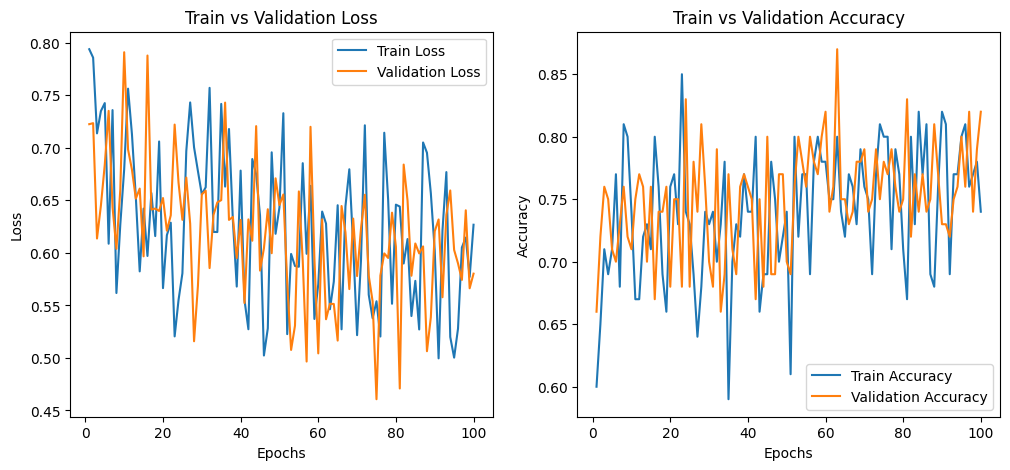

In [18]:
import matplotlib.pyplot as plt

# Epochs의 범위 설정
epochs_range = range(1, len(train_loss_list) + 1)

# Loss 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_list, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.show()

## 평가 함수

In [19]:
import torch

def evaluate_triplet(model, dataloader, loss_fn, device):
    """
    테스트 또는 검증 데이터셋에 대해 모델을 평가하는 함수.
    
    Parameters:
    - model: 평가할 모델
    - dataloader: 평가에 사용할 데이터로더
    - loss_fn: 손실 함수 (예: 트리플렛 손실)
    - device: 연산을 수행할 디바이스 (CPU 또는 GPU)
    
    Returns:
    - avg_loss: 평균 손실
    - accuracy: 정확도
    """
    model.eval()
    total_loss = 0
    correct_pairs = 0
    total_samples = 0

    with torch.no_grad():
        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            loss = loss_fn(anchor_output, positive_output, negative_output)
            total_loss += loss.item()

            # Calculate accuracy
            pos_distance = torch.nn.functional.pairwise_distance(anchor_output, positive_output)
            neg_distance = torch.nn.functional.pairwise_distance(anchor_output, negative_output)

            correct_pairs += torch.sum(pos_distance < neg_distance).item()
            total_samples += anchor.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_pairs / total_samples
    
    return avg_loss, accuracy

## 평가

In [20]:
# 테스트 데이터셋에 대한 평가
test_loss, test_accuracy = evaluate_triplet(model, test_loader, triplet_loss_fn, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4803
Test Accuracy: 0.8200
